# Fully learned reconstruction

In the following exercise we will train a notebook for solving the directly the Inverse Problem
$$\varphi_\Theta: Y \to X$$

Given $N$ training pairs $S = \{(y^\delta_i, x^\dagger_i)\}$ we will train the network by minimizing the loss function 

$$L_S(\Theta) = \frac{1}{N}\sum_{i=1}^N \Vert \varphi_\Theta(y^\delta_i) - x_i^\dagger \Vert$$

## Load the data

In [1]:
import numpy as np
from skimage.transform import radon, iradon

n, m = 28, 28

###############################################
# TODO: Set number of angles
angles = 5
###############################################

detectors = 40

theta = np.linspace(0.0, 180.0, angles, endpoint=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


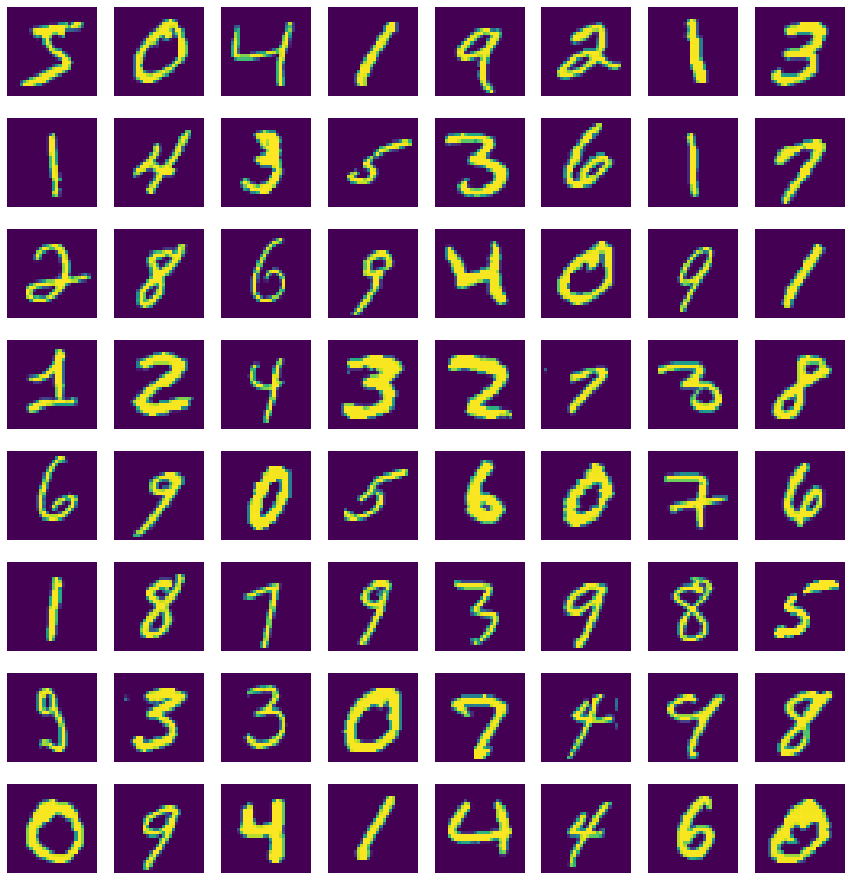

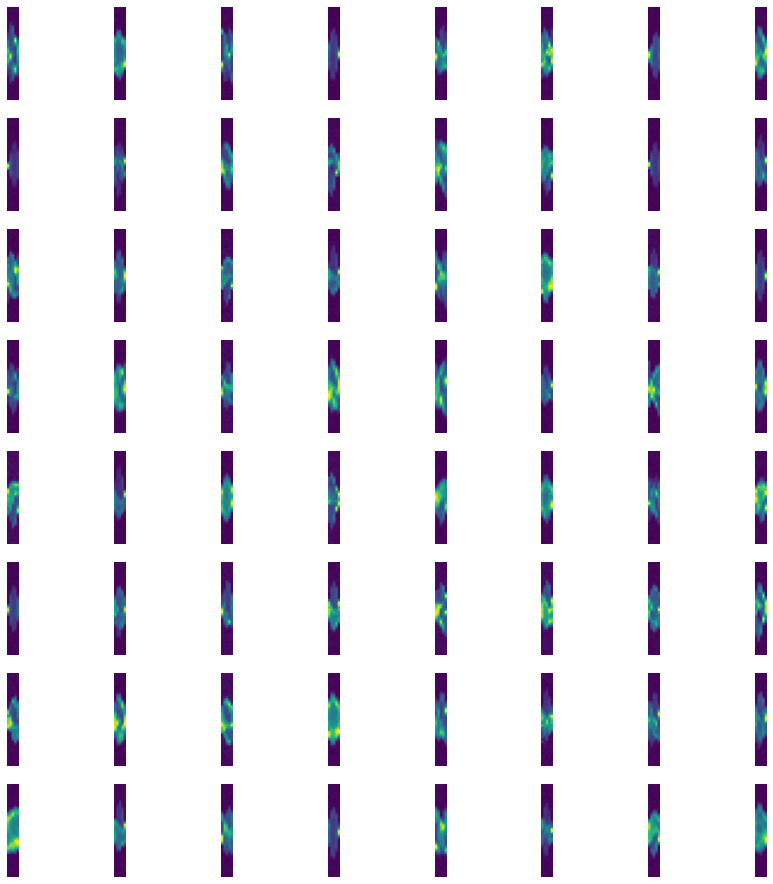

In [2]:
import torch

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import Dataset

batch_size = 64

transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


def forward(phantom):
    sinogram = radon(np.array(phantom).squeeze(), theta, circle=False)
    sinogram += 0.1 * np.random.normal(size=sinogram.shape)
    return sinogram


class SinogramData(Dataset):
    def __init__(self, dataset, forward):
        super(SinogramData, self).__init__()
        self.dataset = dataset

        self.sinograms = []
        for i in range(len(self.dataset)):
            x = self.dataset[i][0]
            self.sinograms.append(torch.tensor(forward(x), dtype=torch.float32))
        self.forward = forward
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        y = self.sinograms[idx]
        return x, y
    
# datasets (MNIST)
mnist_train = SinogramData(datasets.MNIST('/data', train=True, download=True, transform=transform_train), forward)
mnist_test  = SinogramData(datasets.MNIST('/data', train=False, download=True, transform=transform_test), forward)

# dataloaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)


def visualize_batch(batch, ncols=8):
    nrows = (batch.shape[0] + ncols - 1) // ncols
    plt.figure(figsize=(15, 2 * nrows))
    for i in range(batch.shape[0]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(batch[i].squeeze())
        plt.axis('off')
    plt.show()


x_batch, y_batch = next(iter(train_loader))
visualize_batch(x_batch)
visualize_batch(y_batch)

## Create the neural network

In [4]:
import torch.nn as nn
import torch.nn.functional as F

###############################################
# TODO1: Create a network with only one linear layer (as in the regression example)
# TODO2: Add more layers (after running the first time)
model = nn.Sequential(nn.Linear(angles * detectors, 500), nn.Tanh(), nn.Linear(500, 500), nn.Tanh(), nn.Linear(500, n * m))
###############################################

print(model)

Sequential(
  (0): Linear(in_features=200, out_features=500, bias=True)
  (1): Tanh()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): Tanh()
  (4): Linear(in_features=500, out_features=784, bias=True)
)


## Set the hyperparameters, the loss function and the optimizer

In [5]:
import torch.optim as optim

# learning rate
lr = 0.001

# number of epochs
n_epochs = 20

###############################################
# TODO: Choose the loss function
loss_function = nn.MSELoss()
###############################################


###############################################
# TODO: Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr)
###############################################

# set device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Train the network

In [8]:
from skimage.measure import compare_psnr

model.to(device)

# iterate over epochs
for i in range(n_epochs):
  
    train_loss = 0.0
    test_loss = 0.0

    model.train()
    # iterate over batches
    for j, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        ######################################################
        # TODO: Compute the output and do the backprop
        optimizer.zero_grad()
        outputs = model(y.view(-1, angles * detectors))
        loss = loss_function(outputs.view(-1, 1, n, m), x)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ######################################################

        train_loss += loss.item() * x.shape[0]
        if j % 200 == 0:
            print('%d/%d' % (j, len(train_loader)))
      
    
    model.eval()
    with torch.set_grad_enabled(False):
        # iterate on batches
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            
            ######################################################
            # TODO: Evaluate the performance of the current parameters
            outputs = model(y.view(-1, angles * detectors))
            loss = loss_function(outputs.view(-1, 1, n, m), x)
            ######################################################

            test_loss += loss.item() * x.shape[0]

    train_loss /= len(mnist_train)
    test_loss /= len(mnist_test)

    print('epoch: %d train-error: %.5f test-error: %.4f' % (i, train_loss, test_loss))

0/938
200/938
400/938
600/938
800/938
epoch: 0 train-error: 0.02221 test-error: 0.0211
0/938
200/938
400/938
600/938
800/938
epoch: 1 train-error: 0.01495 test-error: 0.0197
0/938
200/938
400/938
600/938
800/938
epoch: 2 train-error: 0.01344 test-error: 0.0157
0/938
200/938
400/938
600/938
800/938
epoch: 3 train-error: 0.01264 test-error: 0.0157
0/938
200/938
400/938
600/938
800/938
epoch: 4 train-error: 0.01207 test-error: 0.0148
0/938
200/938
400/938
600/938
800/938
epoch: 5 train-error: 0.01167 test-error: 0.0155
0/938
200/938
400/938
600/938
800/938
epoch: 6 train-error: 0.01132 test-error: 0.0137
0/938
200/938
400/938
600/938
800/938
epoch: 7 train-error: 0.01101 test-error: 0.0134
0/938
200/938
400/938
600/938
800/938
epoch: 8 train-error: 0.01077 test-error: 0.0131
0/938
200/938
400/938
600/938
800/938
epoch: 9 train-error: 0.01058 test-error: 0.0130
0/938
200/938
400/938
600/938
800/938
epoch: 10 train-error: 0.01039 test-error: 0.0131
0/938
200/938
400/938
600/938
800/938
epoc

## Evaluate the average performance (PSNR)

In [14]:
from skimage.metrics import peak_signal_noise_ratio


def PSNR(imtrue, imother):
    return peak_signal_noise_ratio(imtrue, imother, data_range=imtrue.max()-imtrue.min())

model.eval()

psnr = 0

# iterate on batches
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    outputs = model(y.view(-1, angles * detectors))
    outputs = outputs.view(-1, 1, n, m)
    
    for j in range(x.shape[0]):
        psnr += PSNR(x[j].cpu().numpy(), outputs[j].detach().cpu().numpy())
        
psnr /= len(mnist_test)
print(psnr)

19.728252611737947


## Show some examples

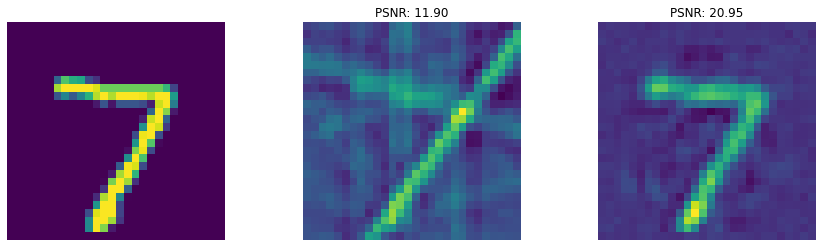

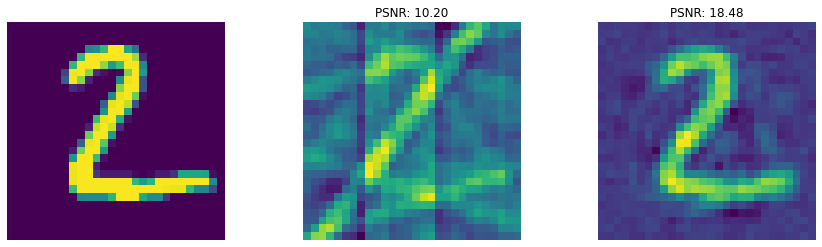

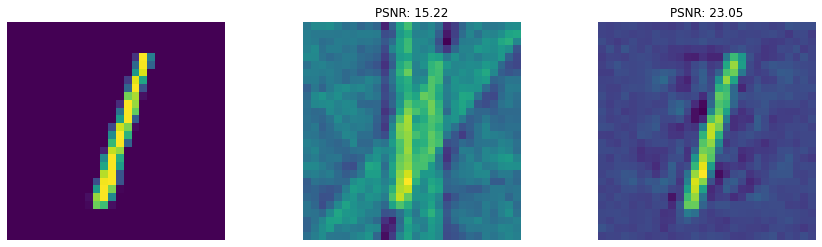

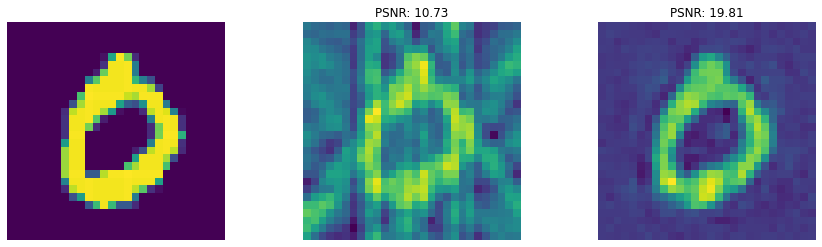

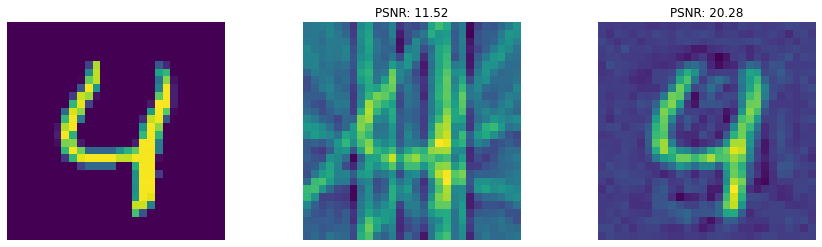

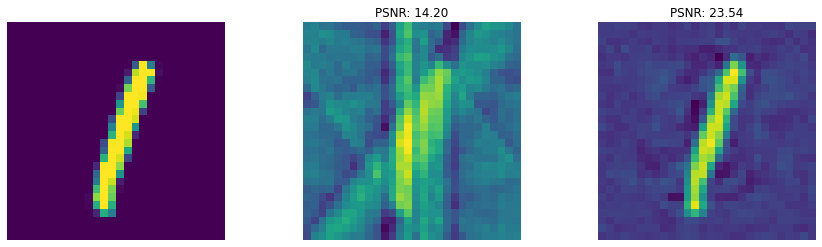

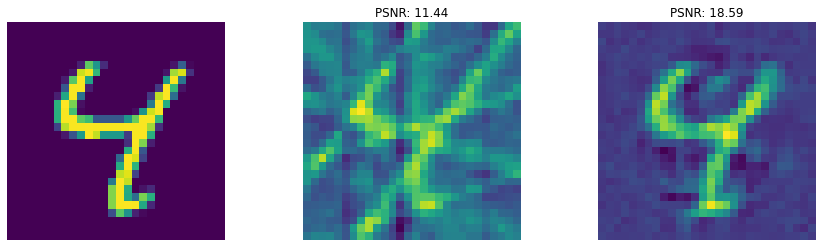

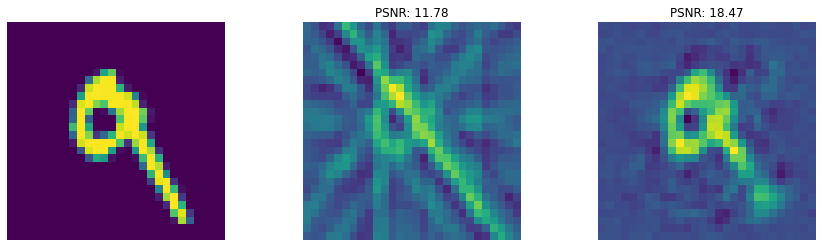

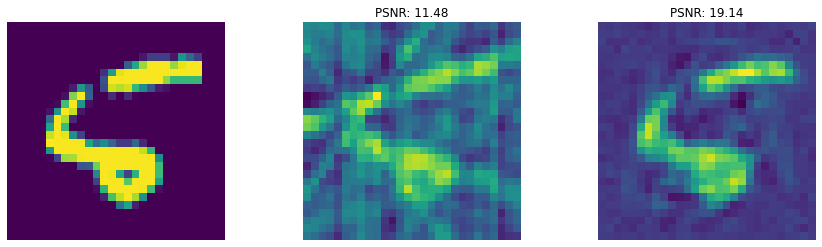

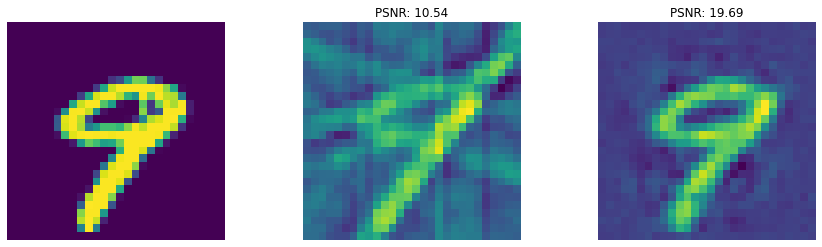

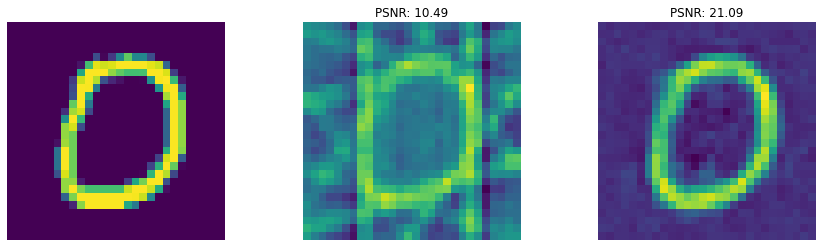

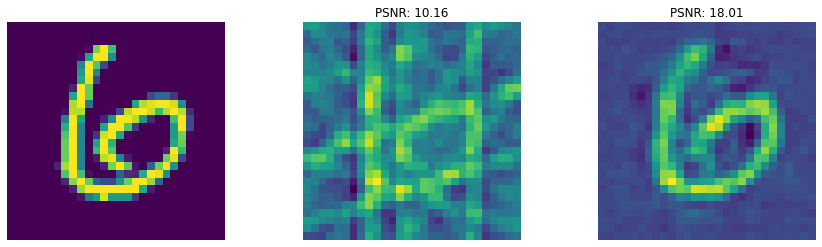

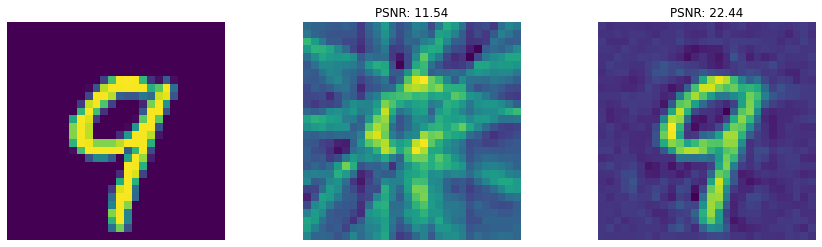

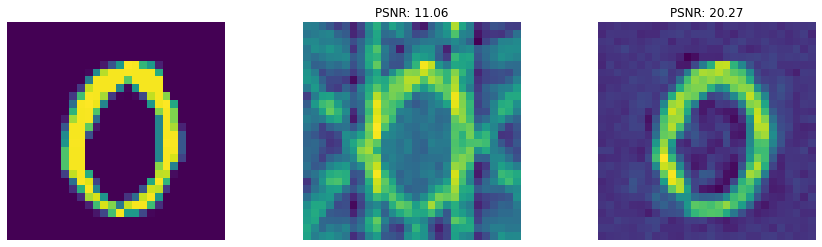

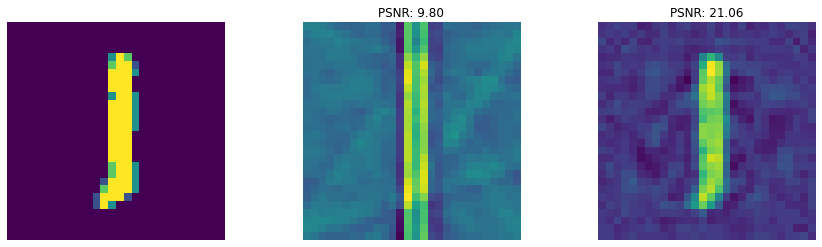

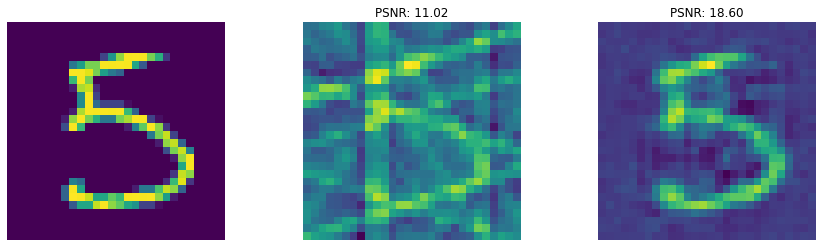

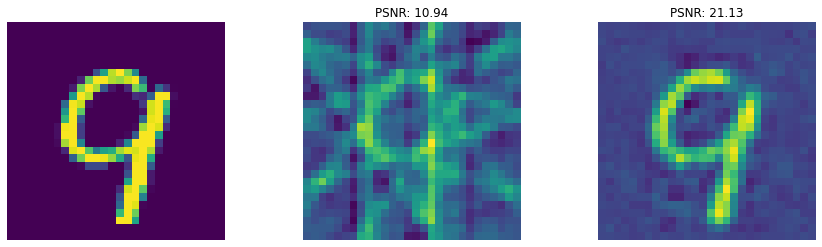

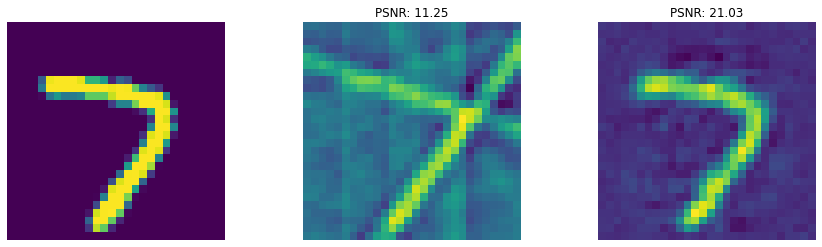

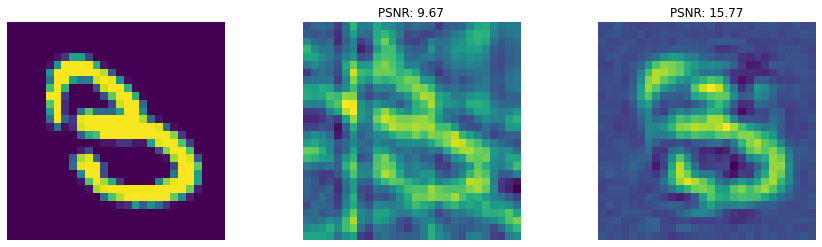

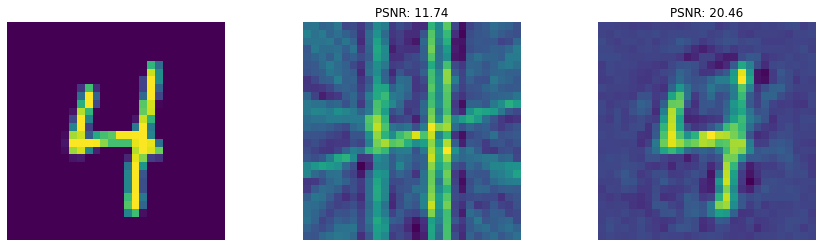

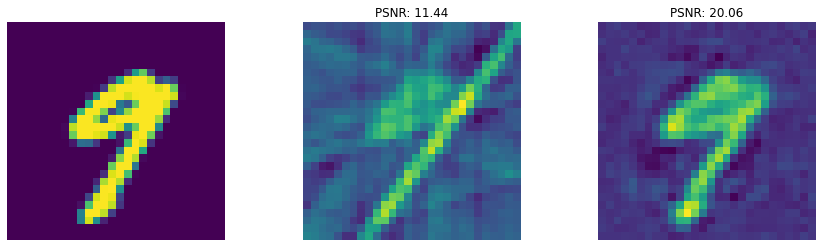

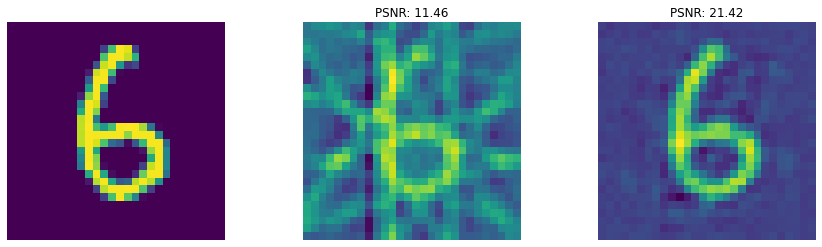

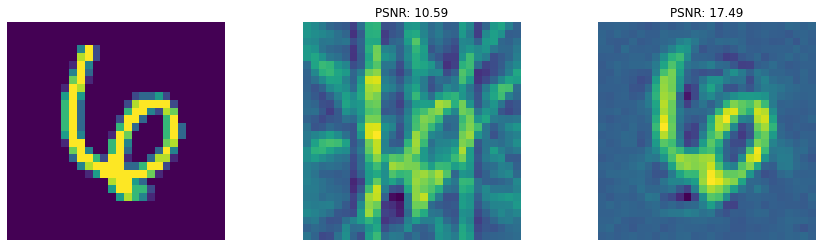

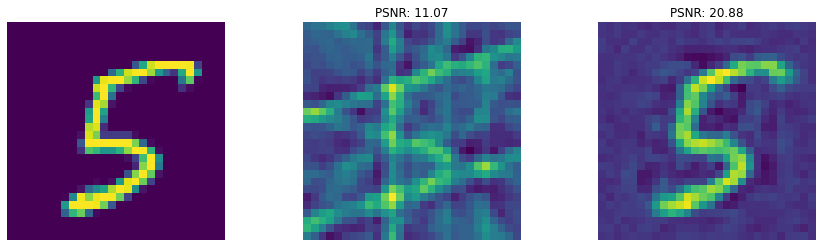

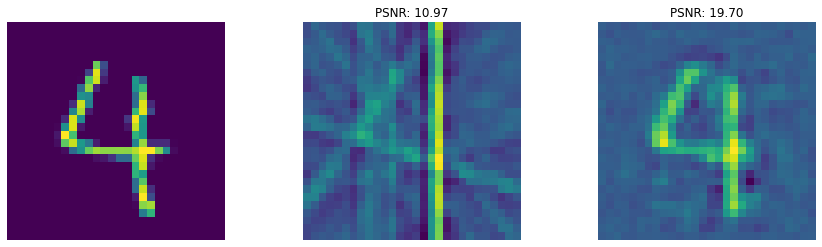

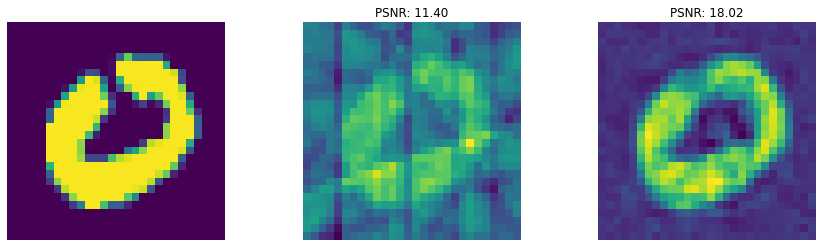

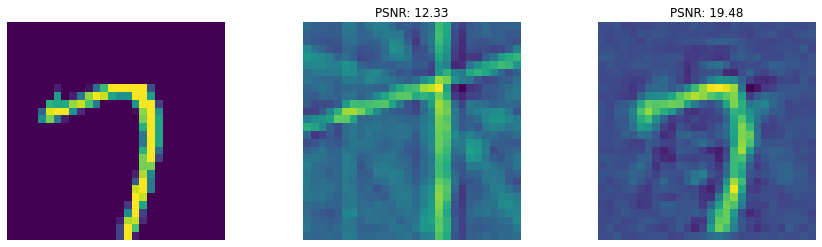

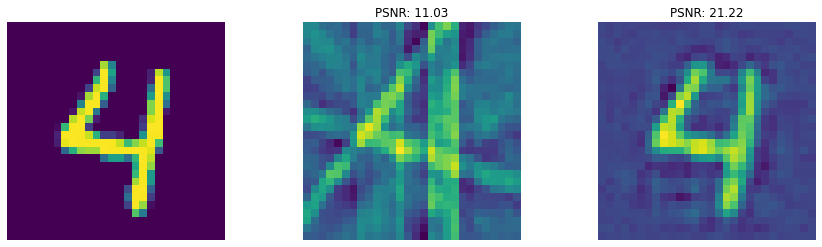

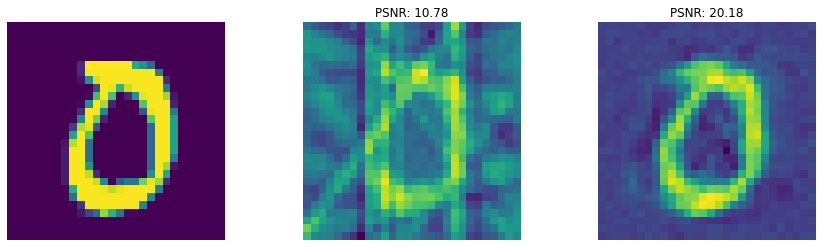

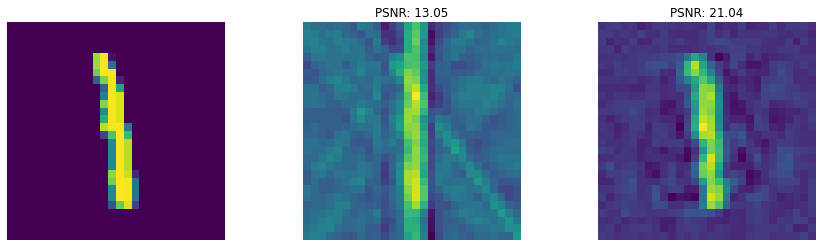

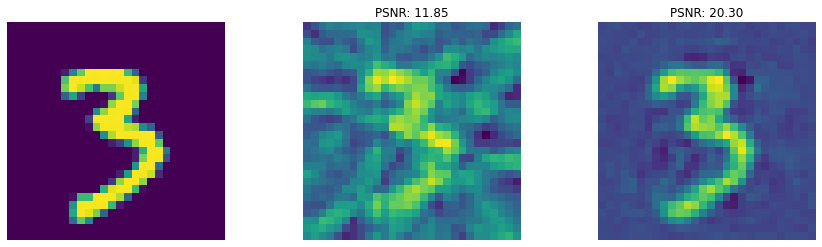

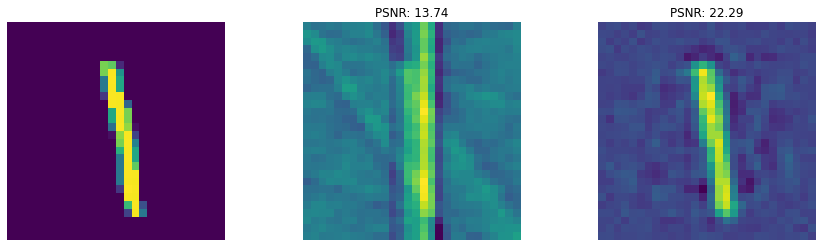

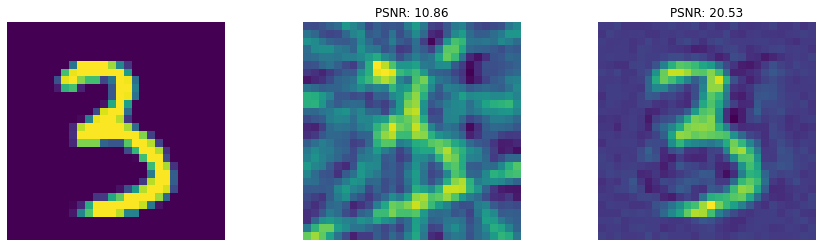

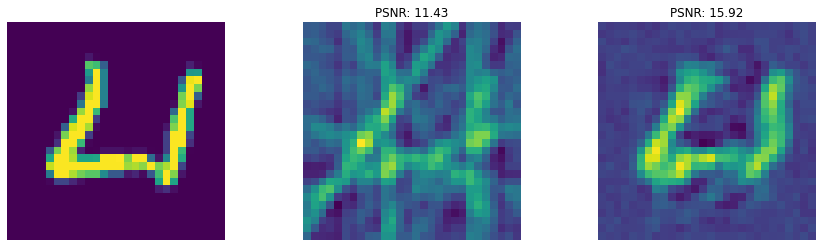

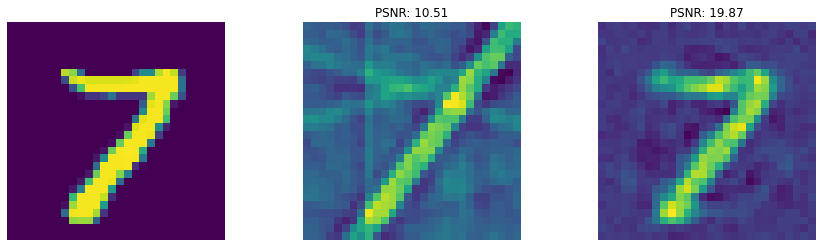

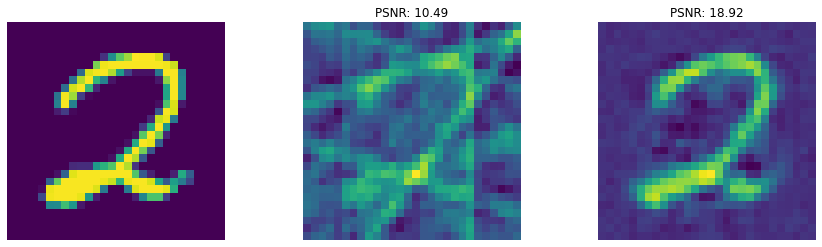

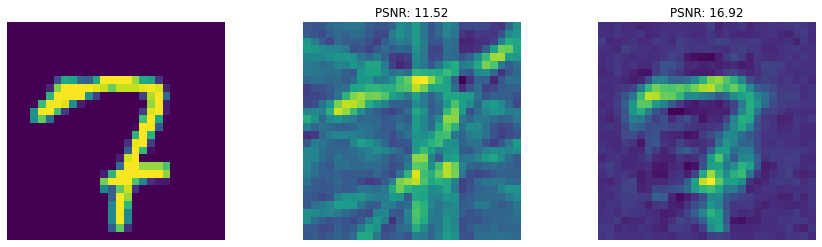

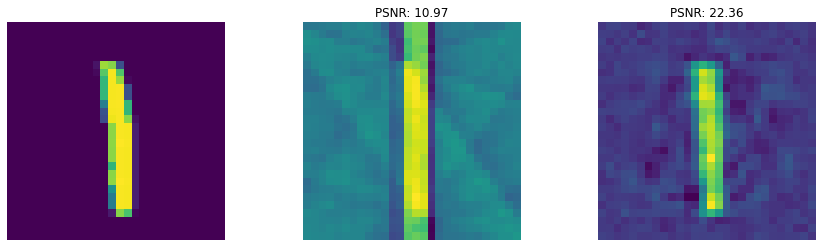

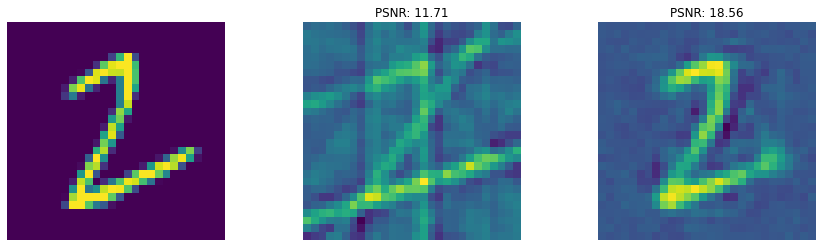

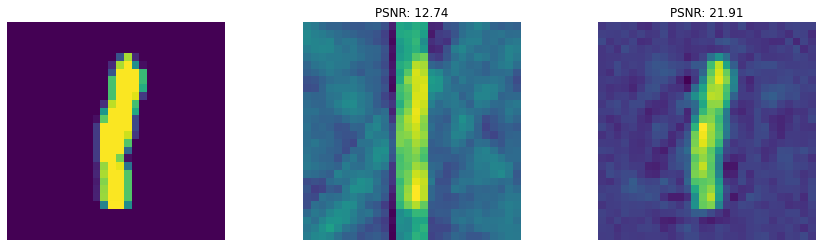

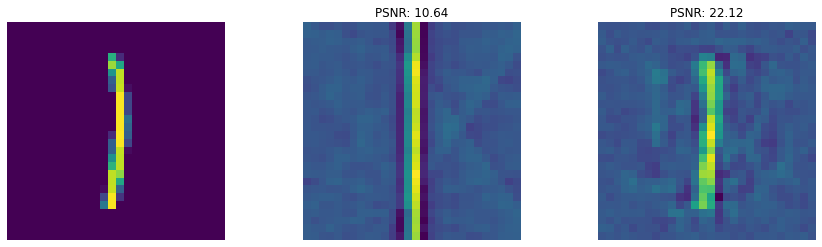

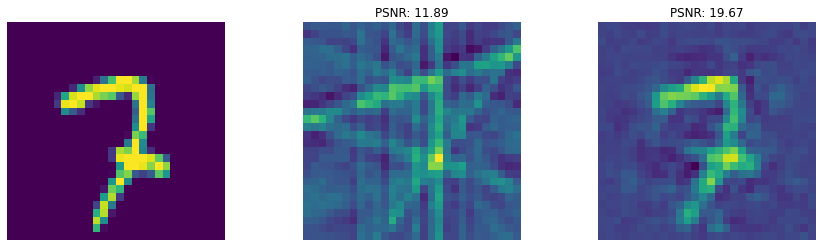

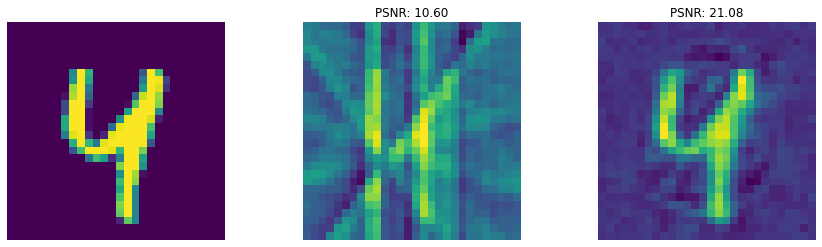

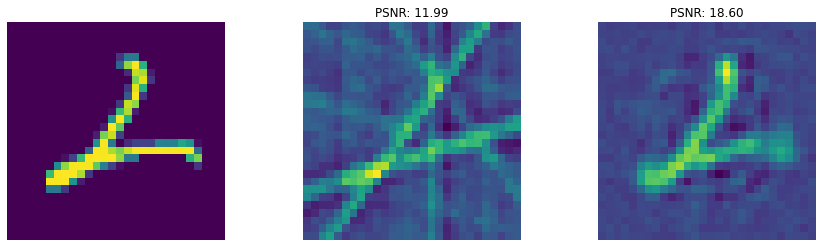

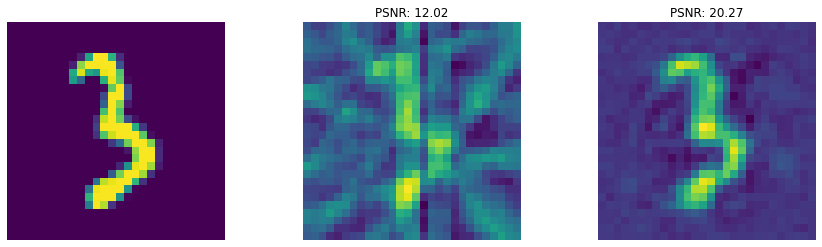

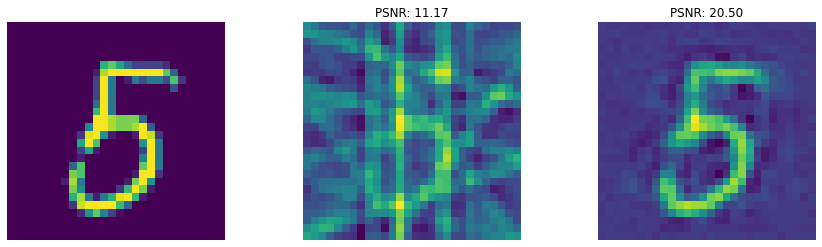

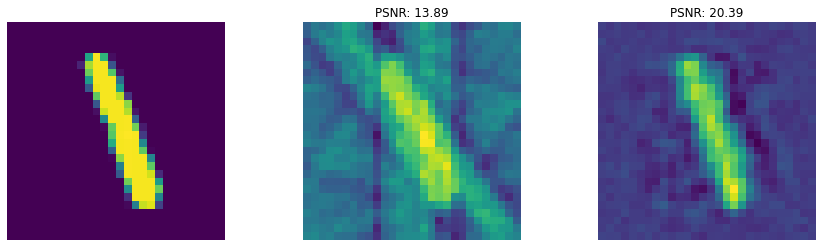

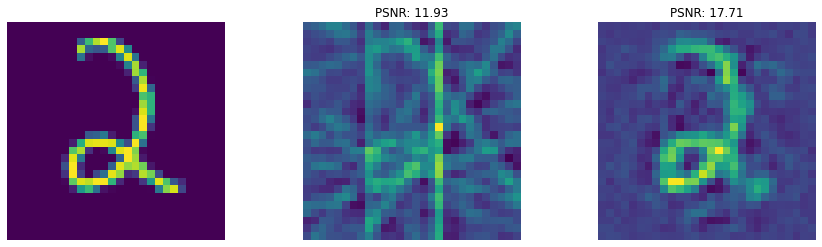

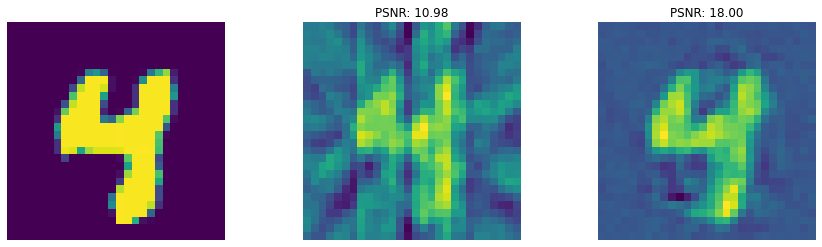

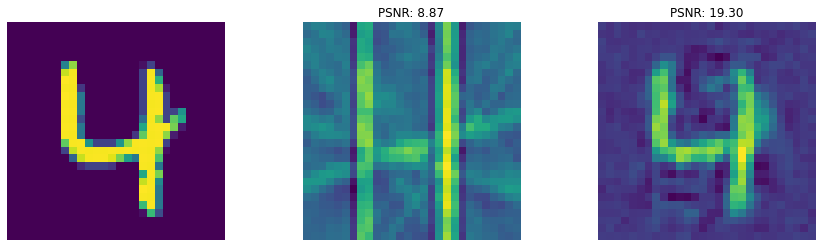

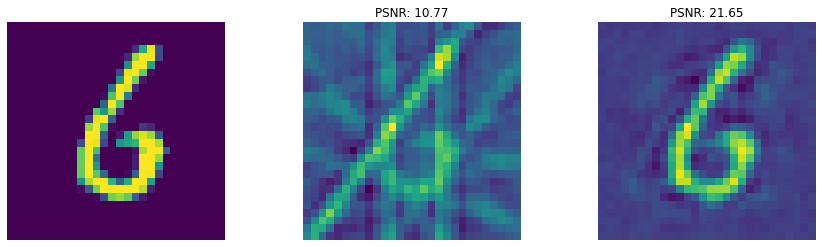

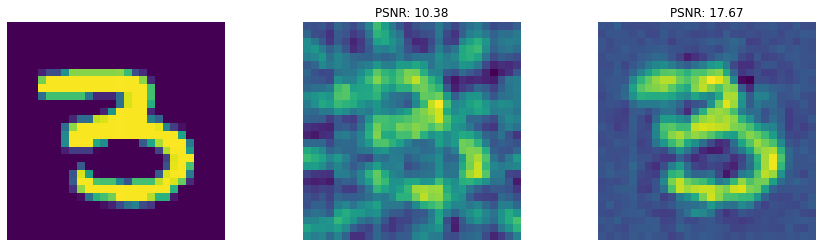

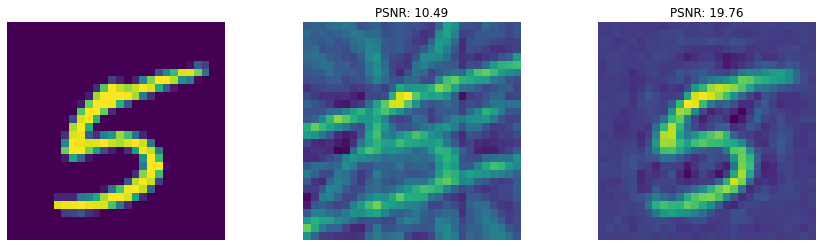

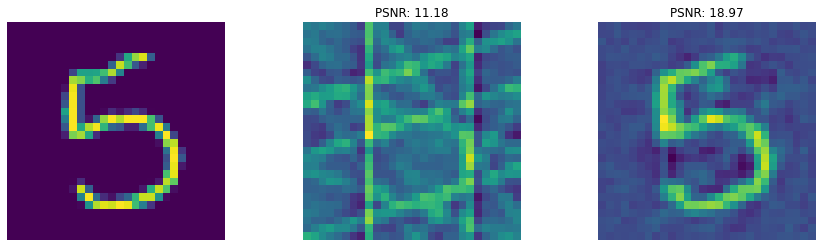

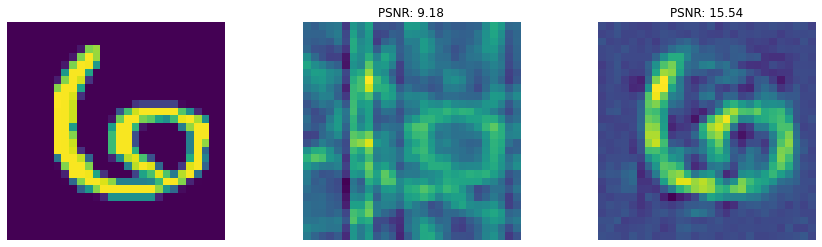

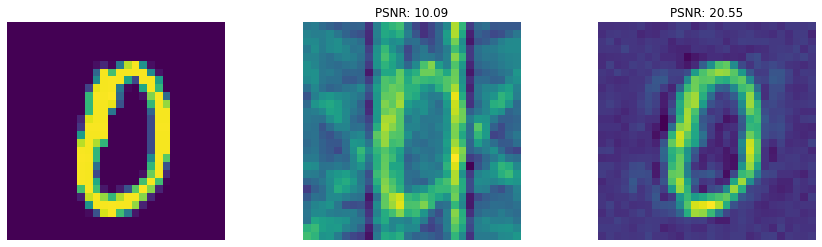

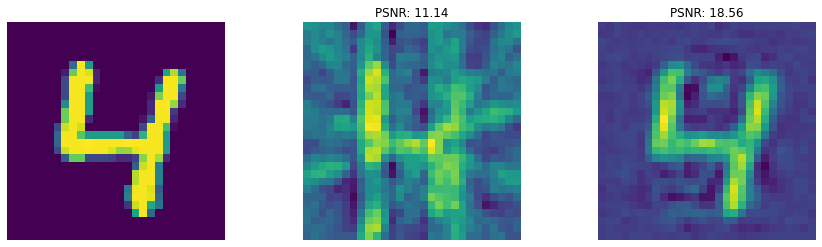

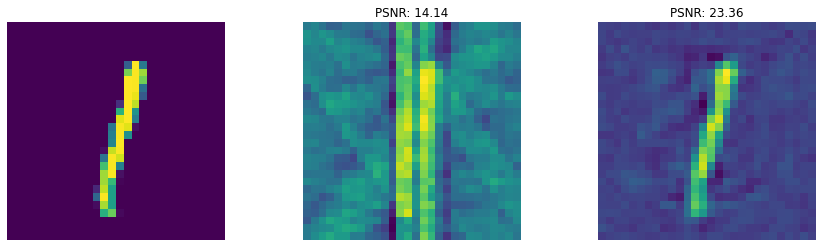

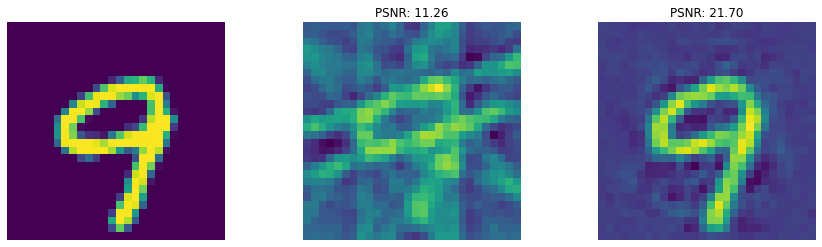

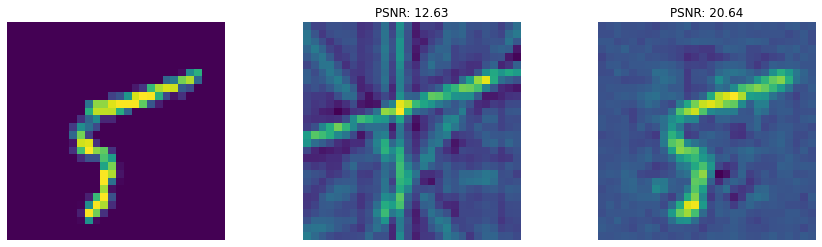

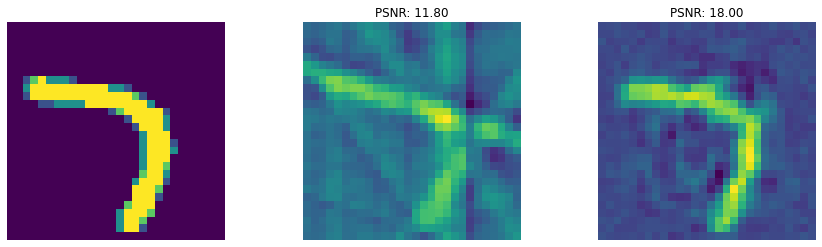

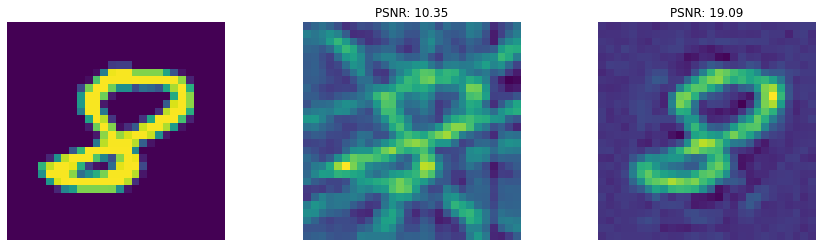

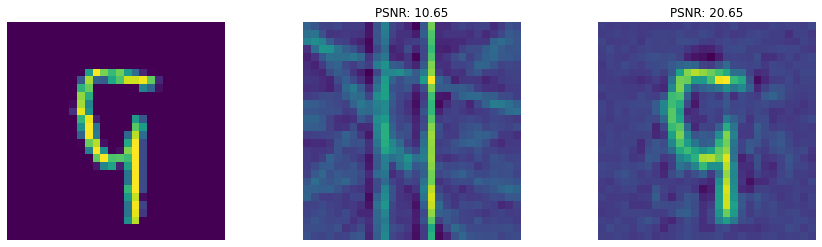

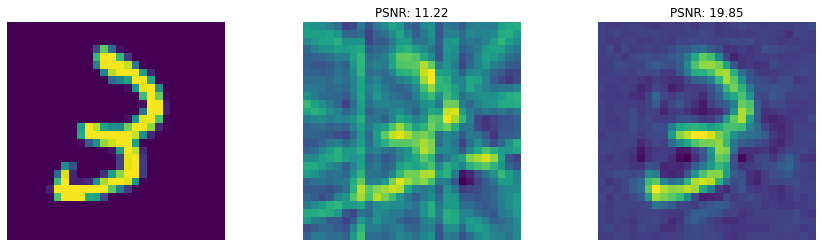

In [23]:
import torch.nn.functional as F
from skimage.transform import iradon


model.eval()

# first batch of data pairs
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

########################################################
# TODO compute the output of the network
outputs = model(y.view(-1, angles * detectors))
outputs = outputs.view(-1, 1, n, m)
########################################################

for i in range(x.shape[0]):
    plt.figure(figsize=(15, 4))
   
    plt.subplot(1,3,1)
    
    plt.imshow(x[i].cpu().squeeze())
    plt.axis('off')
    
    plt.subplot(1,3,2)
    
    # compute direct inverse
    x_rec = iradon(y[i].cpu(), theta=theta, circle=False)
    plt.imshow(x_rec)
    psnr1 = PSNR(x[i][0].cpu().numpy(), x_rec)
    
    plt.title('PSNR: %.2f' % psnr1)
    plt.axis('off')

    plt.subplot(1,3,3)
    psnr2 = PSNR(x[i].cpu().numpy(), outputs[i].detach().cpu().numpy())
    plt.title('PSNR: %.2f' % psnr2)
    
    plt.imshow(outputs[i].detach().cpu().numpy().squeeze())
    plt.axis('off')
    
    plt.show()